In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from loadmodules import *

datadir = "/home/pdcg/Documents/post_process_routines/"
sim = "lvl5_test_cfe"

# Try with h5py only

In [5]:
snaps = np.int_(np.linspace(0, 5, 6))

for i in snaps:
    name_file = 'snapdir_058/snapshot_058.{:01d}.hdf5'.format(i)
    f = h5py.File(datadir+name_file, 'r')
    if i==0:
        cfe = np.array(f['PartType4/ClusterFormationEfficiency'])
        sfe = np.array(f['PartType4/StarFormationEfficiency'])
        Nclus = np.array(f['PartType4/NumberOfClusters'])
        Mclus = np.array(f['PartType4/MassInClusters'])
        mtrunc = np.array(f['PartType4/ICMFTruncationMass'])
    else:
        cfe = np.concatenate((cfe, np.array(f['PartType4/ClusterFormationEfficiency'])), axis=0)
        sfe = np.concatenate((sfe, np.array(f['PartType4/StarFormationEfficiency'])), axis=0)
        Nclus = np.concatenate((Nclus, np.array(f['PartType4/NumberOfClusters'])), axis=0)
        Mclus = np.concatenate((Mclus, np.array(f['PartType4/MassInClusters'])), axis=0)
        mtrunc = np.concatenate((mtrunc, np.array(f['PartType4/ICMFTruncationMass'])), axis=0)


# ICMF sampling test

In [2]:
s_clusterpdir = gadget_readsnap(86, snappath=datadir+sim, loadonlytype=[4], applytransformationfacs=True)

/home/pdcg/pylib/gadget_snap.py:699: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


In [3]:
solar_mass_g = 1.989e33

In [4]:
mclus = s_clusterpdir.data['mclt'][s_clusterpdir.data['nclt']>0] * s_clusterpdir.UnitMass_in_g/solar_mass_g
mtrunc = s_clusterpdir.data['mtrc'][s_clusterpdir.data['nclt']>0] * s_clusterpdir.UnitMass_in_g/solar_mass_g

In [5]:
def ICMF(m, mtrunc):
    return np.exp(-m/mtrunc)/m**2

def trapz_log(min, max, mtrunc, IMF, n):
    integral = 0.
    h = (np.log10(max) - np.log10(min))/n
    low = np.log10(min)
    for i in range(n):
        current = 10**(low + i*h)
        next = 10**(low + (i+1)*h)
        dx = abs(current - next)
        integral += 0.5*dx*(IMF(current, mtrunc) + IMF(next, mtrunc))
    return integral

In [6]:
min = 5e3 #s_clusterpdir.UnitMass_in_g/solar_mass_g
max = 1e8 #s_clusterpdir.UnitMass_in_g/solar_mass_g
marray = np.logspace(np.log10(min), np.log10(max), 50)

In [7]:
norm = 1/trapz_log(min, max, mtrunc, ICMF, 500)

In [8]:
ICMF_array=[]

for i in range(len(mtrunc)):
    ICMF_array.append(norm[i] * ICMF(marray, mtrunc[i]))

ICMF_array = np.array(ICMF_array)

In [9]:
mclus[mclus>0].flatten().max()

33139.3175656558

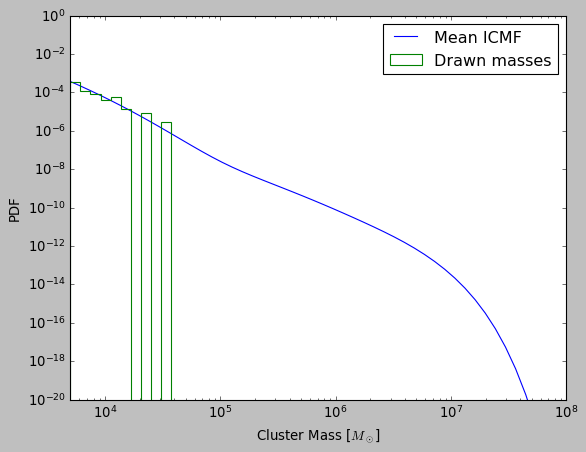

In [10]:
plt.loglog(marray, ICMF_array.mean(axis=0), label='Mean ICMF')
# plt.hist(mclus/Nclus, bins=marray, density=True, histtype='step', label='Drawn masses')
plt.hist(mclus[mclus>0].flatten(), bins=marray, density=True, histtype='step', label='Drawn masses')
plt.legend()
plt.ylim(1e-20, 1e0)
plt.xlim(min, max)
plt.xlabel(r'Cluster Mass [$M_\odot$]')
plt.ylabel('PDF')
plt.savefig('icmf_sampling_test.pdf')

# Compare CFE and SFE

In [12]:
cfe_thrdir = s_clusterpdir.data['lcfe'][s_clusterpdir.data['lcfe']>0]
# cfe_nothrdir = s_nothrdir.data['lcfe'][s_nothrdir.data['age']>0]
# cfe_throlddir = s_throlddir.data['lcfe'][s_throlddir.data['lcfe']>0]
# cfe_nothrolddir = s_nothrolddir.data['lcfe'][s_nothrolddir.data['age']>0]

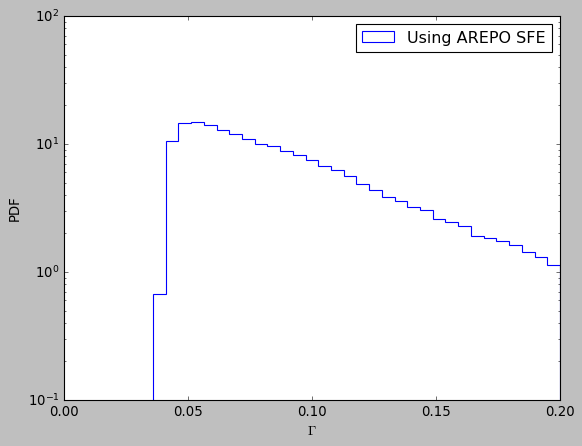

In [13]:
bin = np.linspace(0, 0.2, 40)
plt.hist(cfe_thrdir, bins = bin, density=True, histtype='step', label='Using AREPO SFE')
# plt.hist(cfe_nothrdir, bins = bin, density=True, histtype='step', label='nothr')
# plt.hist(cfe_throlddir, bins = bin, density=True, histtype='step', label='Using SFE from Kruijssen12+')
# plt.hist(cfe_nothrolddir, bins = bin, density=True, histtype='step', label='nothrold')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\Gamma$')
plt.ylabel('PDF')
plt.savefig('CFEcompare.pdf')

# CFE and Age

In [30]:
age_thrdir = s_thrdir.data['age'][s_thrdir.data['lcfe']>0]
z_thrdir = age_thrdir**(-1) - 1
age_gyr = s_thrdir.cosmology_get_lookback_time_from_a(age_thrdir, is_flat=True)

In [35]:
mask = s_thrdir.data['nclt'][s_thrdir.data['lcfe']>0]>0

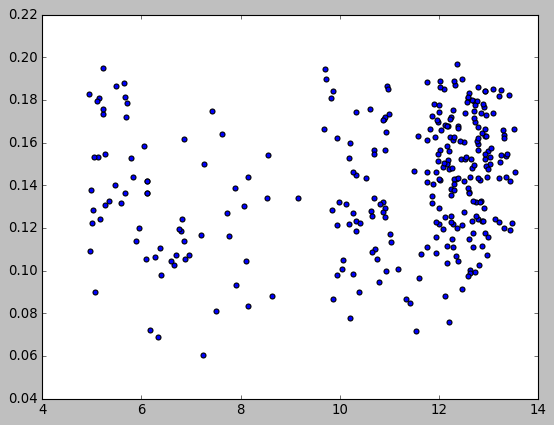

In [36]:
plt.scatter(age_gyr[mask], cfe_thrdir[mask])
# plt.xscale('log')
# plt.xlim(1e0,9e-2)
# plt.yscale('log')